### I. Import and Standardize Data

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Suppress FutureWarning messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Set display format for numbers
pd.options.display.float_format = '{:,.0f}'.format

In [4]:
# Prep format of numbers showing up on y-axis
from matplotlib.ticker import FuncFormatter
# Define the formatting function
def format_func(value, tick_number):
    return "{:,.0f}".format(value)

In [5]:
# Import historical contract data
folder = 'C:/Users/Eliza Bui/Calculate ARR/'
file_name = 'Historical Contract Data EB2024.csv'
file_path = folder + file_name

raw_data = pd.read_csv(file_path)

In [6]:
# Take a look at overall structure
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1488 entries, 0 to 1487
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Invoice Number  1488 non-null   int64 
 1   Customer ID     1488 non-null   object
 2   Invoice Amount  1488 non-null   int64 
 3   Contract Start  1488 non-null   object
 4   Contract End    1488 non-null   object
 5   Product A       1488 non-null   int64 
 6   Product B       1488 non-null   int64 
 7   Product C       1488 non-null   int64 
 8   Product D       1488 non-null   int64 
 9   Client Size     855 non-null    object
 10  Client Type     855 non-null    object
dtypes: int64(6), object(5)
memory usage: 128.0+ KB


In [7]:
# Standardize data type in each column
raw_data['Contract Start'] = pd.to_datetime(raw_data['Contract Start'])
raw_data['Contract End'] = pd.to_datetime(raw_data['Contract End'])

# Take a peek into data
raw_data.head()

,Invoice Number,Customer ID,Invoice Amount,Contract Start,Contract End,Product A,Product B,Product C,Product D,Client Size,Client Type
0,3437,C000001,23600,2018-01-02,2019-07-01,0,1,1,0,5000 to 9999,Type A
1,3852,C000001,18400,2018-12-15,2019-12-14,0,1,1,0,5000 to 9999,Type A
2,3728,C000001,36000,2019-08-02,2021-02-01,0,1,1,0,5000 to 9999,Type A
3,4167,C000001,24500,2019-09-11,2021-09-10,0,1,1,0,5000 to 9999,Type A
4,4219,C000001,8800,2019-11-02,2020-11-01,0,1,1,0,5000 to 9999,Type A


### II. Add in Calculated Fields

In [8]:
# Define a function to map the month to the corresponding quarter - could update based on Fiscal Year
def get_fiscal_quarter(month):
    if month.month < 4:
        return 'Q1'
    elif month.month < 7:
        return 'Q2'
    elif month.month < 10:
        return 'Q3'
    else:
        return 'Q4'

def get_fiscal_year(month):
    if month.month < 7:
        return month.year
    elif month.month < 7:
        return month.year+1

In [9]:
# Calculate the difference in months with fractional
def month_diff(d1, d2):
    years_diff = d2.year - d1.year
    months_diff = d2.month - d1.month
    days_diff = d2.day+1 - d1.day
    # calculate total months
    total_months = years_diff * 12 + months_diff
    # adjust for the cases for fractional month
    if days_diff < 0:
        total_months -= 1
    fractional_months = days_diff / 30
    return total_months + fractional_months

def year_diff(d1, d2):
    years_diff = d2.year - d1.year
    months_diff = d2.month - d1.month
    days_diff = d2.day+1 - d1.day
    
    total_years = years_diff + months_diff / 12 + days_diff / 365
    return total_years

In [10]:
# Group by 'Customer ID' and calculate dates and fiscal period for client cohort
raw_data['Client Earliest Start Date'] = pd.to_datetime(raw_data.groupby('Customer ID')['Contract Start'].transform('min'))

# Calculate the 'Client Cohort Start Month' as the first day of the month of 'Client Earliest Start Date'
raw_data['Client Cohort Start Month'] = raw_data['Client Earliest Start Date'].dt.to_period('M').dt.to_timestamp()

# Apply the function to calculate the 'Client Cohort Start Quarter'
raw_data['Client Cohort Start FQ'] = raw_data['Client Cohort Start Month'].apply(get_fiscal_quarter)

# Apply the function to calculate the 'Client Cohort Start Year'
raw_data['Client Cohort Start FY'] = raw_data['Client Cohort Start Month'].apply(get_fiscal_year)

# Get contract length in months with fractional
raw_data['Contract Length (months)'] = raw_data.apply(lambda x: month_diff(x['Contract Start'], x['Contract End']), axis=1)

# Get contract length in years with fractional
raw_data['Contract Length (years)'] = raw_data.apply(lambda x: year_diff(x['Contract Start'], x['Contract End']), axis=1)

# Calculate contract length in days between start and end, inclusive
raw_data['Contract Length (days)'] = (raw_data['Contract End'] - raw_data['Contract Start']).dt.days + 1

# Calculate annualized contract value using fractional year
raw_data['Annualized Contract Value'] = raw_data.apply(lambda row: row['Invoice Amount'] if row['Contract Length (days)'] < 366 
                                                       else row['Invoice Amount']/row['Contract Length (years)'], axis=1)

# Calculate daily amount
raw_data['Daily Amount'] = raw_data['Invoice Amount'] / raw_data['Contract Length (days)']


In [11]:
# Make sure 2 decimal places are shown
pd.set_option('display.float_format', '{:,.2f}'.format)

# Take a peek into data
#raw_data[raw_data['Invoice Number'] == 4365]
raw_data.head()

,Invoice Number,Customer ID,Invoice Amount,Contract Start,Contract End,Product A,Product B,Product C,Product D,Client Size,Client Type,Client Earliest Start Date,Client Cohort Start Month,Client Cohort Start FQ,Client Cohort Start FY,Contract Length (months),Contract Length (years),Contract Length (days),Annualized Contract Value,Daily Amount
0,3437,C000001,23600,2018-01-02,2019-07-01,0,1,1,0,5000 to 9999,Type A,2018-01-02,2018-01-01,Q1,"2,018.00",18.00,1.50,546,"15,733.33",43.22
1,3852,C000001,18400,2018-12-15,2019-12-14,0,1,1,0,5000 to 9999,Type A,2018-01-02,2018-01-01,Q1,"2,018.00",12.00,1.00,365,"18,400.00",50.41
2,3728,C000001,36000,2019-08-02,2021-02-01,0,1,1,0,5000 to 9999,Type A,2018-01-02,2018-01-01,Q1,"2,018.00",18.00,1.50,550,"24,000.00",65.45
3,4167,C000001,24500,2019-09-11,2021-09-10,0,1,1,0,5000 to 9999,Type A,2018-01-02,2018-01-01,Q1,"2,018.00",24.00,2.00,731,"12,250.00",33.52
4,4219,C000001,8800,2019-11-02,2020-11-01,0,1,1,0,5000 to 9999,Type A,2018-01-02,2018-01-01,Q1,"2,018.00",12.00,1.00,366,"8,800.00",24.04


In [12]:
# Take a look at overall structure
#raw_data.info()

### III. EDA

#### 1. Contract Length Review

In [13]:
# Take a look at main sstistic for contract length columns
raw_data[['Contract Length (years)', 'Contract Length (days)']].describe()

,Contract Length (years),Contract Length (days)
count,"1,488.00","1,488.00"
mean,1.96,715.73
std,0.73,267.96
min,0.08,28.00
25%,1.50,546.00
50%,2.00,730.00
75%,2.50,914.00
max,4.00,"1,461.00"


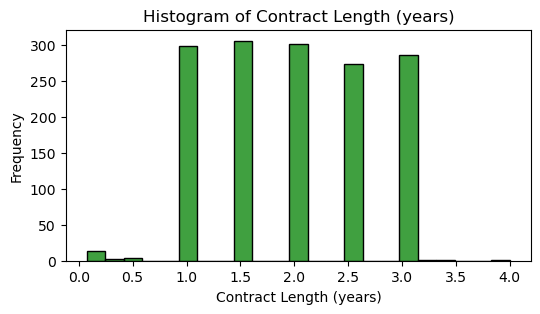

In [14]:
# Create subplots for the histogram
fig, ax = plt.subplots(figsize=(6, 3))

# Plot the histogram for 'Contract Length (years)'
sns.histplot(data = raw_data, x='Contract Length (years)', color='green', ax=ax)
ax.set_title('Histogram of Contract Length (years)')
ax.set_xlabel('Contract Length (years)')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

#### 2. Invoice Amount or Total Contract Value (TCV)

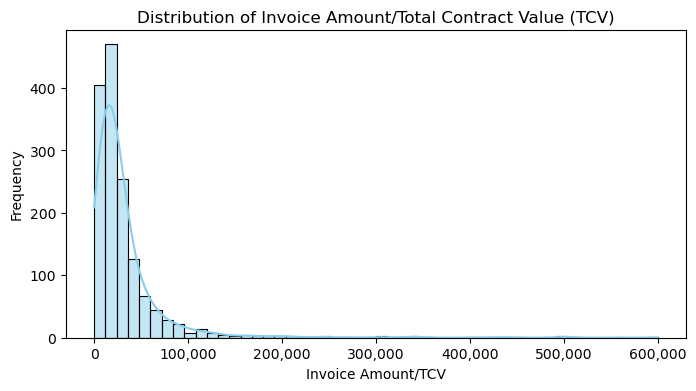

In [15]:
# Create the distribution plot
plt.figure(figsize=(8, 4))
sns.histplot(data=raw_data, x='Invoice Amount', kde=True, color='skyblue', bins=50)

# Set the title and labels
plt.title('Distribution of Invoice Amount/Total Contract Value (TCV)')
plt.xlabel('Invoice Amount/TCV')
plt.ylabel('Frequency')

# Apply the formatting function to the y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

In [16]:
# Get the statistical summary
raw_data[['Invoice Amount']].describe()

,Invoice Amount
count,"1,488.00"
mean,"32,532.54"
std,"50,588.06"
min,0.00
25%,"10,500.00"
50%,"19,700.00"
75%,"33,800.00"
max,"600,000.00"


In [17]:
# Exclude contracts with TCV = $0
data1 = raw_data[raw_data['Invoice Amount'] > 0]
# Rename the 'Invoice Amount' column to "TCV excluding $0 deals"
data1 = data1.rename(columns={'Invoice Amount': 'TCV excluding $0 deals'})
# Get the statistical summary
data1[['TCV excluding $0 deals']].describe()

,TCV excluding $0 deals
count,"1,471.00"
mean,"32,908.51"
std,"50,757.92"
min,"1,400.00"
25%,"10,900.00"
50%,"20,000.00"
75%,"34,250.00"
max,"600,000.00"


#### 3. Annualized Contract Value (ACV)

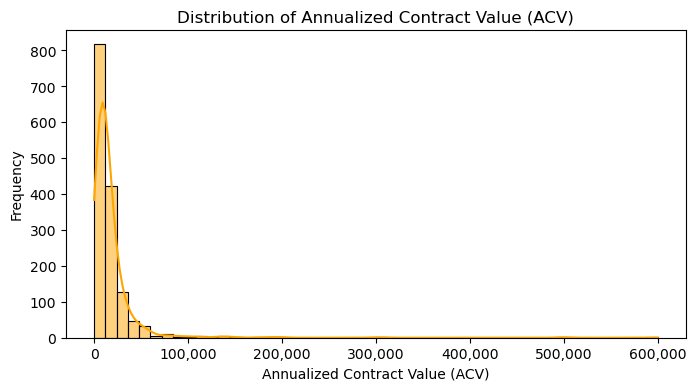

In [18]:
# Create the distribution plot
plt.figure(figsize=(8, 4))
sns.histplot(data=raw_data, x='Annualized Contract Value', kde=True, color='orange', bins=50)

# Set the title and labels
plt.title('Distribution of Annualized Contract Value (ACV)')
plt.xlabel('Annualized Contract Value (ACV)')
plt.ylabel('Frequency')

# Apply the formatting function to the y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

In [19]:
# Take a look at stats
raw_data[['Annualized Contract Value']].describe()

,Annualized Contract Value
count,"1,488.00"
mean,"17,195.95"
std,"31,967.09"
min,0.00
25%,"6,133.33"
50%,"10,500.00"
75%,"18,000.00"
max,"600,000.00"


In [20]:
# Exclude contracts with TCV = $0
data1 = raw_data[raw_data['Invoice Amount'] > 0]
# Rename the 'Invoice Amount' column to "TCV excluding $0 deals"
data1 = data1.rename(columns={'Annualized Contract Value': 'ACV excluding $0 deals'})
# Get the statistical summary
data1[['ACV excluding $0 deals']].describe()

,ACV excluding $0 deals
count,"1,471.00"
mean,"17,394.68"
std,"32,097.57"
min,933.33
25%,"6,150.00"
50%,"10,514.40"
75%,"18,000.00"
max,"600,000.00"


#### 4. Daily Amount or Daily Contract Value (DCV)

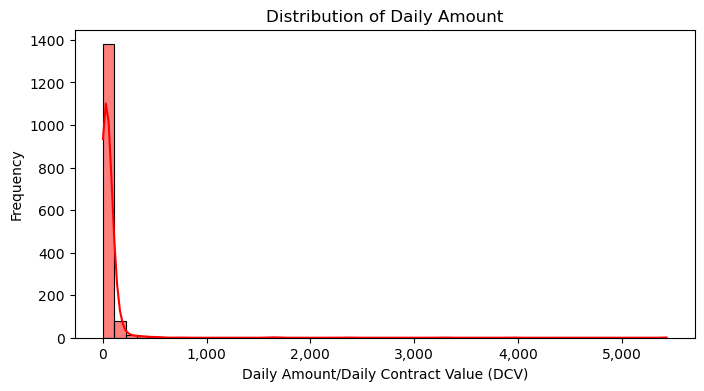

In [21]:
# Create the distribution plot
plt.figure(figsize=(8, 4))
sns.histplot(data=raw_data, x='Daily Amount', kde=True, color='red', bins=50)

# Set the title and labels
plt.title('Distribution of Daily Amount')
plt.xlabel('Daily Amount/Daily Contract Value (DCV)')
plt.ylabel('Frequency')

# Apply the formatting function to the y-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

In [22]:
# Take a look at stats
raw_data[['Daily Amount']].describe()

,Daily Amount
count,"1,488.00"
mean,56.25
std,215.71
min,0.00
25%,16.83
50%,28.78
75%,49.33
max,"5,434.78"


In [23]:
# Exclude contracts with TCV = $0
data1 = raw_data[raw_data['Invoice Amount'] > 0]
# Rename the 'Invoice Amount' column to "TCV excluding $0 deals"
data1 = data1.rename(columns={'Daily Amount': 'DCV excluding $0 deals'})
# Get the statistical summary
data1[['DCV excluding $0 deals']].describe()

,DCV excluding $0 deals
count,"1,471.00"
mean,56.90
std,216.87
min,2.55
25%,18.24
50%,28.79
75%,49.37
max,"5,434.78"


#### 5. All CV Metrics Together

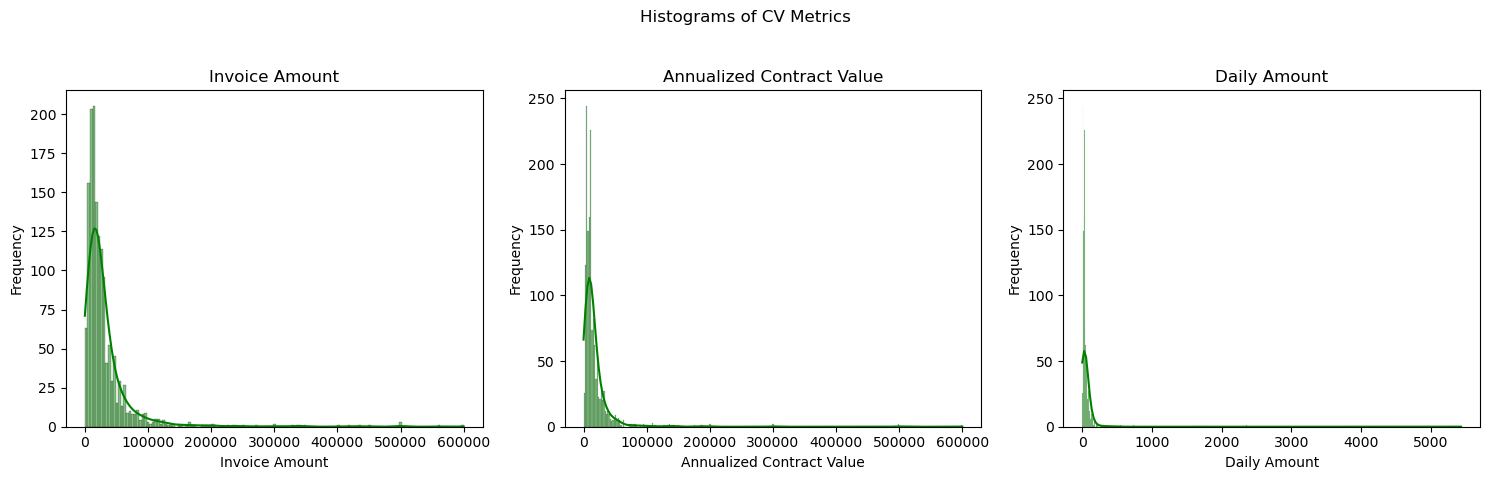

In [24]:
# Define the columns for which you want to create histograms
CV_metrics = ['Invoice Amount', 'Annualized Contract Value', 'Daily Amount']

# Create subplots for the histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Histograms of CV Metrics')

for i, metric in enumerate(CV_metrics):
    sns.histplot(data=raw_data, x=metric, kde=True, color='green', ax=axs[i]) # Updated indexing for axs
    axs[i].set_title(metric) # Updated indexing
    axs[i].set_xlabel(metric) # Updated indexing
    axs[i].set_ylabel('Frequency') # Updated indexing

# Adjust layout for better visual appearance
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect parameters for better title visibility
plt.show()

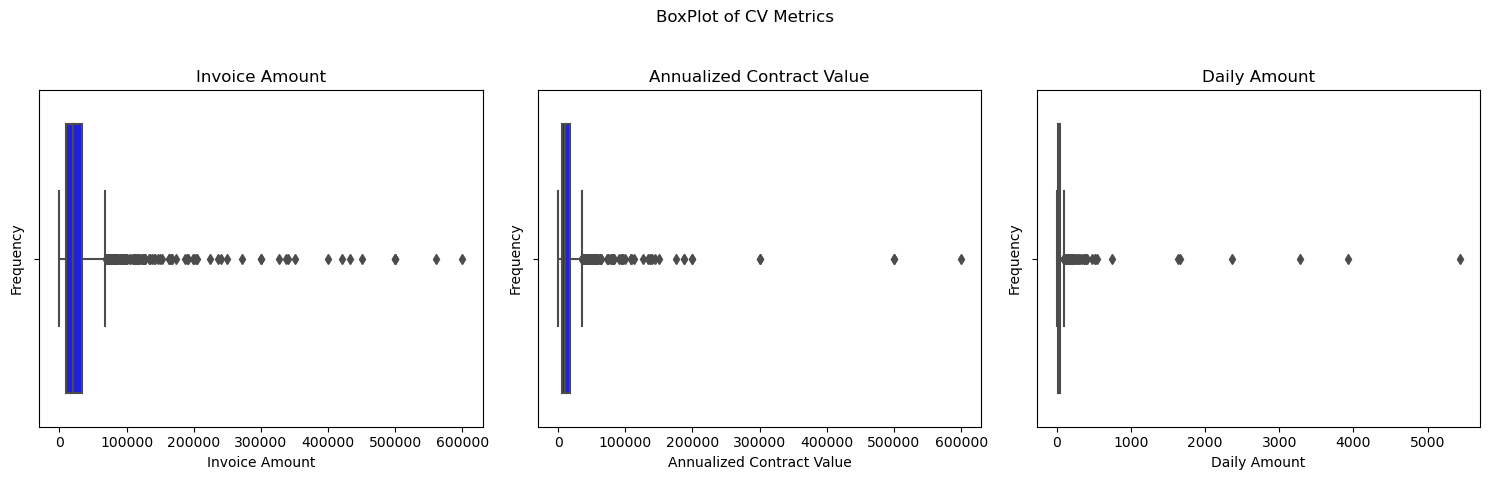

In [25]:
# Define the columns for which you want to create histograms
CV_metrics = ['Invoice Amount', 'Annualized Contract Value', 'Daily Amount']

# Create subplots for the histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('BoxPlot of CV Metrics')

for i, metric in enumerate(CV_metrics):
    sns.boxplot(data=raw_data, x=metric, color='blue', ax=axs[i]) # Updated indexing for axs
    axs[i].set_title(metric) # Updated indexing
    axs[i].set_xlabel(metric) # Updated indexing
    axs[i].set_ylabel('Frequency') # Updated indexing

# Adjust layout for better visual appearance
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect parameters for better title visibility
plt.show()

**Observation:** This dataset clearly has outliers in both Contract Length and ACV that need to be reviewed further. Including outliers that are not truly recurring annually could severly impact the accuracy of ARR calculation

#### Let's cut off the top 2% of ACV values to zoom into the majority 98%

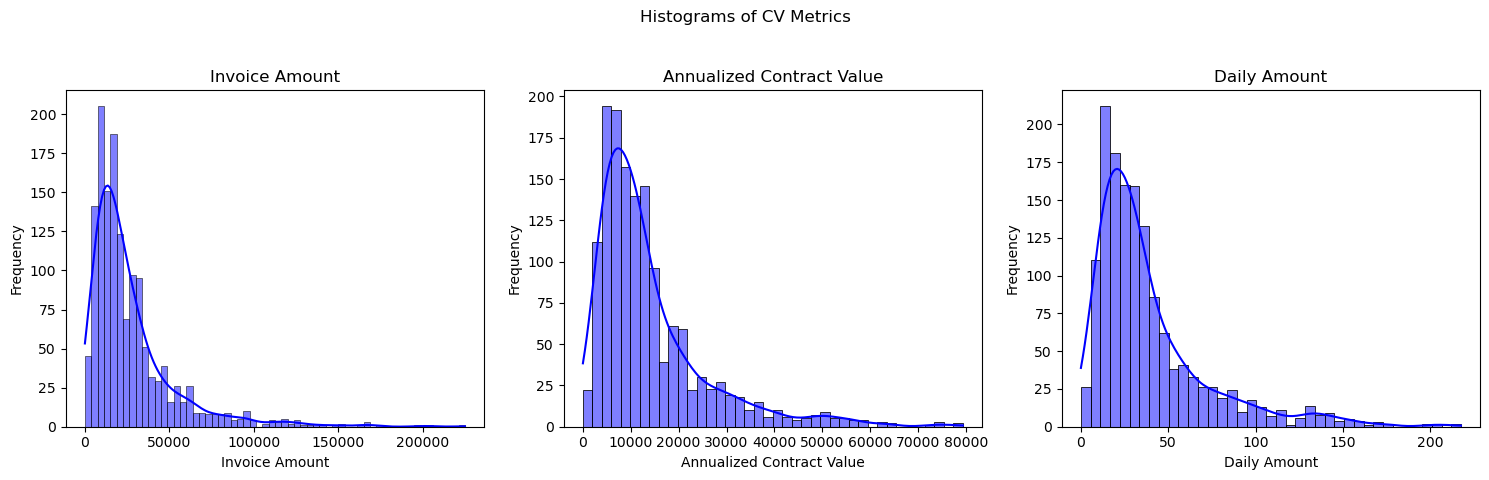

In [26]:
# Calculate the top 2% quantiles
top_quantile = raw_data['Annualized Contract Value'].quantile(0.98)

# Exclude top values from this analysis
no_outlier_df = raw_data[(raw_data['Annualized Contract Value'] < top_quantile )]

# Define the columns for which you want to create histograms
CV_metrics = ['Invoice Amount', 'Annualized Contract Value', 'Daily Amount']

# Create subplots for the histograms
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Histograms of CV Metrics')

for i, metric in enumerate(CV_metrics):
    sns.histplot(data = no_outlier_df, x=metric, kde=True, color='blue', ax=axs[i]) # Updated indexing for axs
    axs[i].set_title(metric) # Updated indexing
    axs[i].set_xlabel(metric) # Updated indexing
    axs[i].set_ylabel('Frequency') # Updated indexing

# Adjust layout for better visual appearance
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust the rect parameters for better title visibility
plt.show()

**Observation:** It's obvious that we need to separate outlier contracts into their own budket to investigate their specific details and determin if they are recurring in nature or not

#### 6. Contract Value vs Contract Length

#### Correlation between ACV and contract length

In [27]:
# Create a correlation matrix
correlation_matrix = raw_data[['Contract Length (years)', 'Annualized Contract Value']].corr()

# Extract correlation value
correlation_value = correlation_matrix.iloc[0, 1]

# Print correlation value
print("Correlation between 'Contract Length (years)' and 'Annualized Contract Value':", correlation_value)

Correlation between 'Contract Length (years)' and 'Annualized Contract Value': -0.09267331490342091


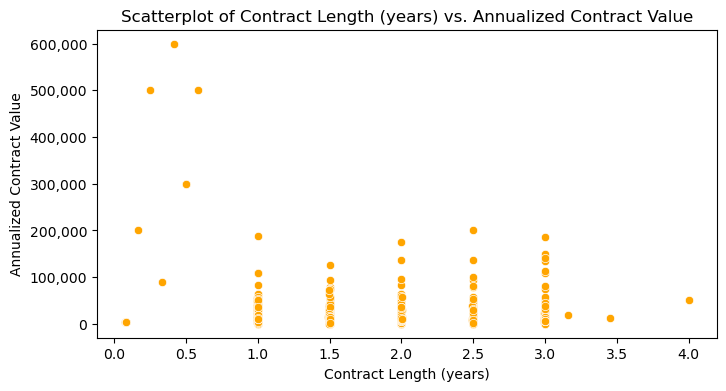

In [28]:
# Plot scatterplot 
plt.figure(figsize=(8, 4))
sns.scatterplot(data = raw_data, x='Contract Length (years)', y='Annualized Contract Value', color='orange')
plt.title('Scatterplot of Contract Length (years) vs. Annualized Contract Value')
plt.xlabel('Contract Length (years)')
plt.ylabel('Annualized Contract Value')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

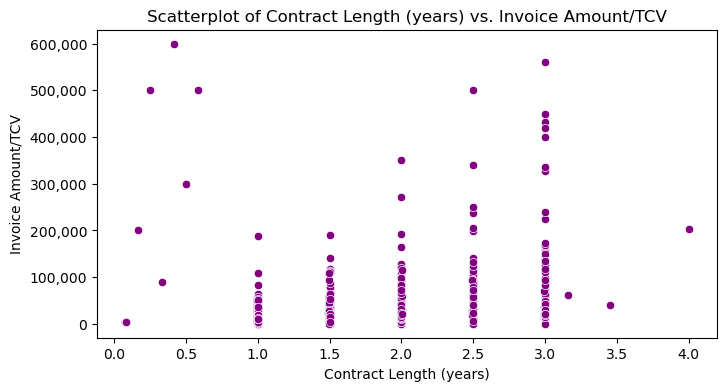

In [29]:
# Plot scatterplot 
plt.figure(figsize=(8, 4))
sns.scatterplot(data = raw_data, x='Contract Length (years)', y='Invoice Amount', color='purple')
plt.title('Scatterplot of Contract Length (years) vs. Invoice Amount/TCV')
plt.xlabel('Contract Length (years)')
plt.ylabel('Invoice Amount/TCV')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))
plt.show()

**Observation:** The 2 scatter plots mimic each other and clearly show that there are a handful of short-term contracts with enormous Invoice Amount/TCV that cause the histogram of TCV, ACV, and DCV to be right skewed. Upon closer investigation, it's pretty clear that these are not annually recurring contracts and thus need to be excluded from ARR calculation

#### 7. Investigate Pareto Principle: Does 80% of TCV comes from top 20% clients?

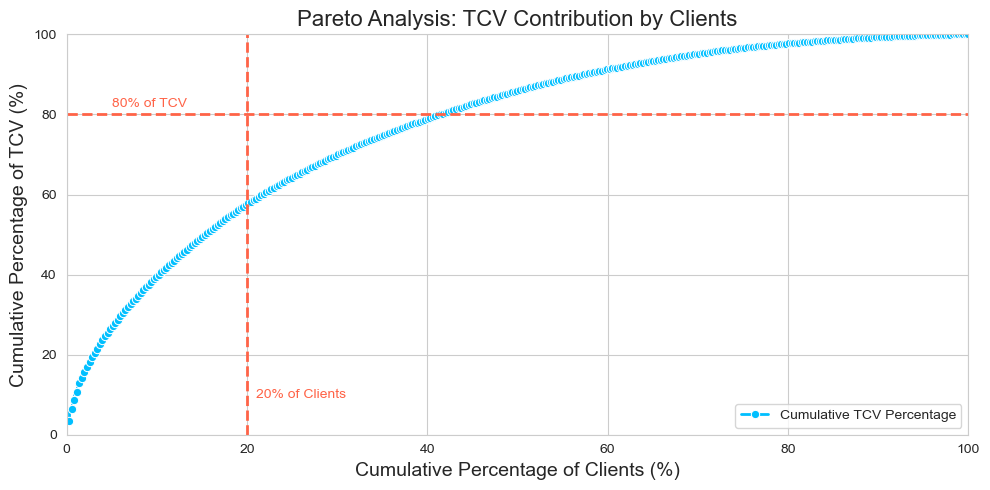

In [30]:
# Calculate TCV per Client
tcv_per_client = raw_data.groupby('Customer ID')['Invoice Amount'].sum().sort_values(ascending=False)

# Convert tcv_per_client to DataFrame
tcv_per_client_df = tcv_per_client.reset_index(name='TCV')

# Correct calculation for Cumulative TCV
# This ensures that the cumulative sum is calculated correctly on the DataFrame's 'TCV' column
tcv_per_client_df['Cumulative TCV'] = tcv_per_client_df['TCV'].cumsum()

# Calculate Cumulative TCV Percentage
tcv_per_client_df['Cumulative TCV Percentage'] = 100 * tcv_per_client_df['Cumulative TCV'] / tcv_per_client_df['TCV'].sum()

# Calculate Cumulative Client Percentage
tcv_per_client_df['Cumulative Client Percentage'] = 100 * np.arange(1, len(tcv_per_client_df) + 1) / len(tcv_per_client_df)

# Plotting the Pareto graph
plt.figure(figsize=(10, 5))

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Line plot for Cumulative TCV Percentage
sns.lineplot(data=tcv_per_client_df, x='Cumulative Client Percentage', y='Cumulative TCV Percentage', 
             drawstyle='steps-pre', marker='o', color='deepskyblue', lw=2, label='Cumulative TCV Percentage')

# Adding a horizontal line at 80% to highlight the Pareto Principle threshold
plt.axhline(80, color='tomato', linestyle='--', lw=2, label='80% TCV')

# Adding a vertical line at 20% to see if the top 20% clients contribute to 80% of TCV
plt.axvline(20, color='tomato', linestyle='--', lw=2, label='20% Clients')

# Adding text annotations for clarity
plt.text(21, 10, '20% of Clients', color='tomato', va='center', ha='left')
plt.text(5, 81, '80% of TCV', color='tomato', va='bottom', ha='left')

# Setting the axes and plot titles, and labels
plt.xlabel('Cumulative Percentage of Clients (%)', fontsize=14)
plt.ylabel('Cumulative Percentage of TCV (%)', fontsize=14)
plt.title('Pareto Analysis: TCV Contribution by Clients', fontsize=16)

# Adjust the plot limits and layout
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()

# Show plot
plt.show()

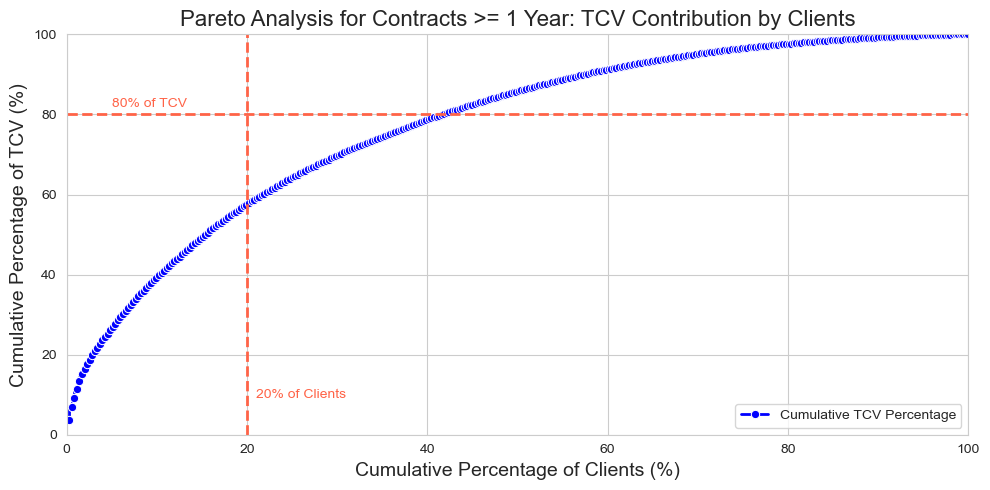

In [31]:
# Filter the dataset for contracts with 'Contract Length (years)' >= 1
filtered_data = raw_data[raw_data['Contract Length (years)'] >= 1]

# Calculate TCV per Client on the filtered dataset
tcv_per_client_filtered = filtered_data.groupby('Customer ID')['Invoice Amount'].sum().sort_values(ascending=False)

# Convert tcv_per_client_filtered to DataFrame
tcv_per_client_df_filtered = tcv_per_client_filtered.reset_index(name='TCV')

# Calculate Cumulative TCV
tcv_per_client_df_filtered['Cumulative TCV'] = tcv_per_client_df_filtered['TCV'].cumsum()

# Calculate Cumulative TCV Percentage
tcv_per_client_df_filtered['Cumulative TCV Percentage'] = 100 * tcv_per_client_df_filtered['Cumulative TCV'] / tcv_per_client_df_filtered['TCV'].sum()

# Calculate Cumulative Client Percentage
tcv_per_client_df_filtered['Cumulative Client Percentage'] = 100 * np.arange(1, len(tcv_per_client_df_filtered) + 1) / len(tcv_per_client_df_filtered)

# Plotting the Pareto graph for the filtered data
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

# Line plot for Cumulative TCV Percentage using the filtered DataFrame
sns.lineplot(data=tcv_per_client_df_filtered, x='Cumulative Client Percentage', y='Cumulative TCV Percentage', 
             drawstyle='steps-pre', marker='o', color='blue', lw=2, label='Cumulative TCV Percentage')

# Adding a horizontal line at 80% to highlight the Pareto Principle threshold
plt.axhline(80, color='tomato', linestyle='--', lw=2, label='80% TCV')

# Adding a vertical line at 20% to see if the top 20% clients contribute to 80% of TCV
plt.axvline(20, color='tomato', linestyle='--', lw=2, label='20% Clients')

# Adding text annotations for clarity
plt.text(21, 10, '20% of Clients', color='tomato', va='center', ha='left')
plt.text(5, 81, '80% of TCV', color='tomato', va='bottom', ha='left')

# Setting the axes and plot titles, and labels
plt.xlabel('Cumulative Percentage of Clients (%)', fontsize=14)
plt.ylabel('Cumulative Percentage of TCV (%)', fontsize=14)
plt.title('Pareto Analysis for Contracts >= 1 Year: TCV Contribution by Clients', fontsize=16)

# Adjust the plot limits and layout
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

**Observation:** The result for ARR-qualified deals is pretty much the same sa for full contract population, with top 40% clients accounting for 80% of TCV that this company has sold

In [32]:
#filtered_data[['Contract Length (years)','Invoice Amount', 'Annualized Contract Value', 'Daily Amount']].describe()

In [33]:
#tcv_per_client_df